# FIN30150: Financial Economics 1: Group Project
Odhran Murphy 19469442

Hugo Brady 19412776

Mark Mullins 19341043

## Import Libraries

In [1]:
# Import the standard data analysis libraries
import pandas as pd
import numpy as np

# Plotting library
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn-darkgrid")
matplotlib.rcParams['figure.figsize']=[8,4]

# OLS Regression Library
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

# Import specific libraries to read in data
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import datetime
from datetime import datetime

# OS Module
import os

# Import other modules
from IPython.display import Markdown

# Import winzorise library
from scipy.stats import mstats
from scipy.stats.mstats import winsorize

## Define Functions

#### `windsorize_ret`

In [2]:
def windsorize_ret(df, cols, lb, ub):
    """Reducing the effect of possible returns for each stock outliers by limiting the extreme values"""
    
    for col in cols:
        winsorize(a=df[col], limits=(lb, ub), inplace=True)

#### `returns_describe`

In [3]:
def returns_describe(series, title):
    """Adding Skewness and Kurtosis to in built describe function"""
    
    stats = series.describe()
    stats.loc['skew'] = series.skew().tolist()
    stats.loc['kurt'] = (series.kurtosis() + 3).tolist() # Python calculates excess kurtosis 
    display(Markdown(f"**{str(title)} Returns Characteristics**"))
    display(stats)

#### `plot_series_v_normal`

In [4]:
def plot_series_v_normal(series, series_label, title):
    """Plot series histogram v normal distribution"""  
    
    # Applying the seaborn distplot function to get histogram & density curve of series 
    sns.histplot(series, kde=True, color='darkblue', stat='density', label = series_label)

    # Normal distribution with the same mean & variance
    np.random.seed(0) # Fixed seed to use

    # Random variable with normal distribution
    normal_sample = np.random.normal(np.mean(series), np.std(series), 249)

    # Applying the Gaussian kernel density estimate to get the density curve
    sns.kdeplot(normal_sample, color='red', shade=True, label = "Normal")
    
    # Calculate series skew and kurtosis
    skewness = series.skew()
    kurtosis = series.kurtosis() + 3 # Python calculates excess kurtosis  
    
    plt.title(title)
    plt.text(-0.12,15, f'Skewness: {skewness:.3f} \nKurtosis: {kurtosis:.3f}')
    plt.xlabel('Returns')
    plt.legend()
    plt.show()

## Download Data

__Dateparsers for Fama French data__

In [5]:
# Dateparser to read in Fama French data so that the pandas read data function
# recognises the date format in the first column (where dates are expressed as 202009 for Sep 2020)
dateparserFF = lambda x: datetime.strptime(x, '%Y%m')

# Check that date parser works on a given date
print(dateparserFF('202009'))

2020-09-01 00:00:00


### Set GitHub Repository

In [6]:
base_url = 'https://raw.githubusercontent.com/odhran-murphy/FE1_Group_Project/main' 

### Read Fama French data

#### 3 factor monthly data

In [7]:
filename = 'FF_data_2022_monthly.csv'
df_ff_3f = pd.read_csv(f'{base_url}/{filename}', parse_dates=['Date'], date_parser=dateparserFF)

#Offset FF data to last business day of month as it should be
df_ff_3f['Date'] = pd.DatetimeIndex(df_ff_3f['Date']) + pd.offsets.BMonthEnd(1) 
df_ff_3f.set_index('Date',inplace=True)
df_ff_3f = df_ff_3f.divide(100)

# Converting all FF column names to lower case to avoid duplicates with SP500 ticker names
df_ff_3f = df_ff_3f.rename(columns=str.lower)

df_ff_3f

,mkt-rf,smb,hml,rf
Date,,,,
1926-07-30,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-29,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2022-05-31,-0.0034,-0.0185,0.0841,0.0003
2022-06-30,-0.0843,0.0209,-0.0597,0.0006
2022-07-29,0.0957,0.0281,-0.0410,0.0008


#### 5 factor monthly data

In [8]:
filename = 'FF_data_2022_monthly_5f.csv'
df_ff_5f = pd.read_csv(f'{base_url}/{filename}', parse_dates=['Date'], date_parser=dateparserFF)

#Offset FF data to last business day of month as it should be
df_ff_5f['Date'] = pd.DatetimeIndex(df_ff_5f['Date']) + pd.offsets.BMonthEnd(1) 
df_ff_5f.set_index('Date',inplace=True)
df_ff_5f = df_ff_5f.divide(100)

# Converting all FF column names to lower case to avoid duplicates with SP500 ticker names
df_ff_5f = df_ff_5f.rename(columns=str.lower)
df_ff_5f

,mkt-rf,smb,hml,rmw,cma,rf
Date,,,,,,
1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1963-08-30,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
1963-11-29,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
...,...,...,...,...,...,...
2022-05-31,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0003
2022-06-30,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0006
2022-07-29,0.0957,0.0188,-0.0410,0.0068,-0.0694,0.0008


_Set start and end dates_

In [9]:
start = datetime(1989,12,1)
end = datetime(2022,12,31)

#### SP500 and SP500 constituents data

##### Download SP500 data

In [10]:
#Download and save dataset (Only download if data has not already been downloaded)
target = 'SP500.csv'

if not os.path.isfile(target):
    df_sp_500 = pdr.get_data_yahoo('^GSPC', start, end, interval = '1mo')
    df_sp_500.to_csv(target)
        
df_sp_500 = pd.read_csv(f'{base_url}/{target}') # Always using saved dataset
df_sp_500.set_index('Date',inplace=True) 
df_sp_500_adj_close = df_sp_500.drop(columns=['Open','High','Low','Close','Volume'])
df_sp_500_adj_close.rename(columns={'Adj Close': 'SP500'}, inplace=True)
df_sp_500_adj_close

,SP500
Date,
1989-12-01,353.399994
1990-01-01,329.079987
1990-02-01,331.890015
1990-03-01,339.940002
1990-04-01,330.799988
...,...
2022-08-01,3955.000000
2022-09-01,3585.620117
2022-10-01,3871.979980


##### Download SP500 constituents data

In [11]:
#Download table with constituents

table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') # reads in tables from url
df_sp500_constituents = table[0] # Table of SP500 constituents at 14th November 2022

# Table of changes of SP500 constituents since 17th June 1997 - Work In Progress - try remove survivorship bias
df_sp500_constituents_changes = table[1] 

# Potential way to remove survivorship bias
# https://teddykoker.com/2019/05/creating-a-survivorship-bias-free-sp-500-dataset-with-python/

display(df_sp500_constituents)

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [12]:
#Download and save dataset (Only download if data has not already been downloaded)
target = 'SP500_constituents_adj_close.csv'

N = len(df_sp500_constituents['Symbol'])
tickers_list = df_sp500_constituents.loc[:N,'Symbol'].tolist()

if not os.path.isfile(target):
    df_sp500_constituents_data = pdr.get_data_yahoo(tickers_list, start, end, interval = '1mo')
    set(df_sp500_constituents_data.columns.get_level_values(0))
    df_sp500_constituents_data = df_sp500_constituents_data['Adj Close']
    df_sp500_constituents_data.to_csv(target)

df_sp500_constituents_data = pd.read_csv(f'{base_url}/{target}') # Always using saved dataset
df_sp500_constituents_data.set_index('Date',inplace=True) 
df_sp500_constituents_data

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-01,NaN,NaN,NaN,0.250664,NaN,NaN,5.500000,1.830009,NaN,NaN,...,NaN,4.172812,4.134922,0.848284,NaN,NaN,NaN,NaN,1.845269,NaN
1990-01-01,NaN,NaN,NaN,0.241775,NaN,NaN,4.562500,1.749274,NaN,NaN,...,NaN,3.965566,3.886824,0.848284,NaN,NaN,NaN,NaN,1.752264,NaN
1990-02-01,NaN,NaN,NaN,0.241775,NaN,NaN,4.562500,1.734572,NaN,NaN,...,NaN,3.885725,3.886824,0.830972,NaN,NaN,NaN,NaN,1.853357,NaN
1990-03-01,NaN,NaN,NaN,0.287141,NaN,NaN,5.125000,1.778527,NaN,NaN,...,NaN,3.872416,3.873215,0.813661,NaN,NaN,NaN,NaN,1.836507,NaN
1990-04-01,NaN,NaN,NaN,0.280900,NaN,NaN,4.750000,1.805578,NaN,NaN,...,NaN,3.566349,3.789470,0.805004,NaN,NaN,NaN,NaN,2.014277,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,128.028427,12.99,167.152359,156.741913,133.105606,145.657196,259.279999,102.167931,45.720001,287.182892,...,60.590000,73.767395,93.914124,32.632450,90.800819,110.697227,106.082695,301.640015,54.205685,156.198105
2022-09-01,121.340004,12.04,154.960861,137.971115,132.858124,134.915085,245.660004,96.305595,45.540001,256.160858,...,63.029999,63.584019,86.612747,28.231003,87.360001,106.339996,104.316650,262.010010,50.448788,147.975571
2022-10-01,138.110977,14.18,189.919998,153.086044,144.925323,156.737976,252.080002,98.475357,57.500000,282.643097,...,63.900002,65.110001,109.925072,30.820000,102.430000,118.250000,113.349998,283.220001,51.520054,150.460297


#### SP100 and SP100 constituents data

##### Download SP100 data

In [13]:
#Download and save dataset (Only download if data has not already been downloaded)
target = 'SP100.csv'

if not os.path.isfile(target):
    df_sp_100 = pdr.get_data_yahoo('^OEX', start, end, interval = '1mo')
    df_sp_100.to_csv(target)
        
df_sp_100 = pd.read_csv(f'{base_url}/{target}') # Always using saved dataset
df_sp_100.set_index('Date',inplace=True) 
df_sp_100_adj_close = df_sp_100.drop(columns=['Open','High','Low','Close','Volume'])
df_sp_100_adj_close.rename(columns={'Adj Close': 'SP100'}, inplace=True)
df_sp_100_adj_close

,SP100
Date,
1989-12-01,164.675003
1990-01-01,153.940002
1990-02-01,156.240005
1990-03-01,160.014999
1990-04-01,157.115005
...,...
2022-08-01,1797.949951
2022-09-01,1625.760010
2022-10-01,1740.510010


##### Download SP100 constituents data

In [14]:
#List of SP100 companies
df_sp100_constituents = pd.read_csv("SP100_list.csv", encoding="latin1")
display(df_sp100_constituents)

,Symbol,Name,Sector
0,AAPL,Apple,Information Technology
1,ABBV,AbbVie,Health Care
2,ABT,Abbott Laboratories,Health Care
3,ACN,Accenture,Information Technology
4,ADBE,Adobe,Information Technology
...,...,...,...
96,VZ,Verizon,Communication Services
97,WBA,Walgreens Boots Alliance,Consumer Staples
98,WFC,Wells Fargo,Financials
99,WMT,Walmart,Consumer Staples


In [15]:
#Download and save dataset (Only download if data has not already been downloaded)
target = 'SP100_constituents_adj_close.csv'

N = len(df_sp100_constituents['Symbol'])
tickers_list = df_sp100_constituents.loc[:N,'Symbol'].tolist()

if not os.path.isfile(target):
    df_sp100_constituents_data = pdr.get_data_yahoo(tickers_list, start, end, interval = '1mo')
    set(df_sp100_constituents_data.columns.get_level_values(0))
    df_sp100_constituents_data = df_sp100_constituents_data['Adj Close']
    df_sp100_constituents_data.to_csv(target)

df_sp100_constituents_data = pd.read_csv(f'{base_url}/{target}') # Always using saved dataset
df_sp100_constituents_data.set_index('Date',inplace=True) 
df_sp100_constituents_data

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-01,0.250664,NaN,1.830009,NaN,1.188340,105.828514,0.765221,NaN,NaN,NaN,...,0.310161,3.211169,NaN,0.872812,NaN,5.769442,1.684878,1.127023,3.515244,4.134919
1990-01-01,0.241775,NaN,1.749273,NaN,1.379061,95.194878,0.730083,NaN,NaN,NaN,...,0.236618,3.141626,NaN,0.761773,NaN,5.069331,1.491162,1.039366,3.343113,3.886824
1990-02-01,0.241775,NaN,1.734571,NaN,1.779085,99.161308,0.897964,NaN,NaN,NaN,...,0.239815,3.210266,NaN,0.761773,NaN,4.706444,1.464131,0.986440,3.450956,3.886824
1990-03-01,0.287141,NaN,1.778528,NaN,2.234883,95.194878,0.964335,NaN,NaN,NaN,...,0.249408,3.062424,NaN,0.771796,NaN,4.942092,1.539057,0.999087,3.705856,3.873216
1990-04-01,0.280900,NaN,1.805578,NaN,2.253144,91.085503,0.999473,NaN,NaN,NaN,...,0.274988,2.894433,NaN,0.812125,NaN,4.896273,1.520950,0.910560,3.897904,3.789472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,156.741898,133.105606,102.167931,287.182892,373.440002,51.444466,236.827271,252.210968,126.769997,494.959656,...,517.705566,223.254196,191.274475,45.081444,197.916306,41.117058,34.245155,43.133423,131.975220,93.914131
2022-09-01,137.971115,132.858124,96.305595,256.160858,275.200012,47.199673,223.858109,213.145813,113.000000,440.317871,...,503.460266,194.820007,160.042877,39.852745,177.253799,37.340702,31.034708,39.962620,129.699997,86.612747
2022-10-01,153.086044,144.925323,98.475357,282.643097,318.500000,57.000000,268.500641,205.690186,102.440002,470.119995,...,555.150024,197.139999,166.215149,42.450001,206.697998,36.750645,36.075378,45.695698,142.330002,109.925072


## Data Manipulation

#### SP500 data manipulation

In [16]:
# Concatenate SP500 and SP500 constituents data
df_sp_500_adj_close_master = pd.merge(df_sp_500_adj_close, df_sp500_constituents_data, how = 'left', left_index=True, right_index=True)

# End of month data but recorded in Python using first day of month
df_sp_500_adj_close_master.head()

,SP500,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-01,353.399994,NaN,NaN,NaN,0.250664,NaN,NaN,5.5000,1.830009,NaN,...,NaN,4.172812,4.134922,0.848284,NaN,NaN,NaN,NaN,1.845269,NaN
1990-01-01,329.079987,NaN,NaN,NaN,0.241775,NaN,NaN,4.5625,1.749274,NaN,...,NaN,3.965566,3.886824,0.848284,NaN,NaN,NaN,NaN,1.752264,NaN
1990-02-01,331.890015,NaN,NaN,NaN,0.241775,NaN,NaN,4.5625,1.734572,NaN,...,NaN,3.885725,3.886824,0.830972,NaN,NaN,NaN,NaN,1.853357,NaN
1990-03-01,339.940002,NaN,NaN,NaN,0.287141,NaN,NaN,5.1250,1.778527,NaN,...,NaN,3.872416,3.873215,0.813661,NaN,NaN,NaN,NaN,1.836507,NaN
1990-04-01,330.799988,NaN,NaN,NaN,0.280900,NaN,NaN,4.7500,1.805578,NaN,...,NaN,3.566349,3.789470,0.805004,NaN,NaN,NaN,NaN,2.014277,NaN


In [17]:
# Correcting data so day of month is business end of month
df_sp_500_adj_close_master.index = pd.to_datetime(df_sp_500_adj_close_master.index)
df_sp_500_adj_close_master = df_sp_500_adj_close_master.resample('BM').last()
df_sp_500_adj_close_master.head()

,SP500,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-29,353.399994,NaN,NaN,NaN,0.250664,NaN,NaN,5.5000,1.830009,NaN,...,NaN,4.172812,4.134922,0.848284,NaN,NaN,NaN,NaN,1.845269,NaN
1990-01-31,329.079987,NaN,NaN,NaN,0.241775,NaN,NaN,4.5625,1.749274,NaN,...,NaN,3.965566,3.886824,0.848284,NaN,NaN,NaN,NaN,1.752264,NaN
1990-02-28,331.890015,NaN,NaN,NaN,0.241775,NaN,NaN,4.5625,1.734572,NaN,...,NaN,3.885725,3.886824,0.830972,NaN,NaN,NaN,NaN,1.853357,NaN
1990-03-30,339.940002,NaN,NaN,NaN,0.287141,NaN,NaN,5.1250,1.778527,NaN,...,NaN,3.872416,3.873215,0.813661,NaN,NaN,NaN,NaN,1.836507,NaN
1990-04-30,330.799988,NaN,NaN,NaN,0.280900,NaN,NaN,4.7500,1.805578,NaN,...,NaN,3.566349,3.789470,0.805004,NaN,NaN,NaN,NaN,2.014277,NaN


In [18]:
# Calculating returns dataframe
df_sp_500_rets = np.log(df_sp_500_adj_close_master/df_sp_500_adj_close_master.shift(1))
df_sp_500_rets.head()

,SP500,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31,-0.071300,NaN,NaN,NaN,-0.036106,NaN,NaN,-0.186877,-0.045120,NaN,...,NaN,-0.050942,-0.061876,0.000000,NaN,NaN,NaN,NaN,-0.051716,NaN
1990-02-28,0.008503,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,-0.008440,NaN,...,NaN,-0.020339,0.000000,-0.020619,NaN,NaN,NaN,NaN,0.056089,NaN
1990-03-30,0.023966,NaN,NaN,NaN,0.171968,NaN,NaN,0.116260,0.025025,NaN,...,NaN,-0.003431,-0.003507,-0.021053,NaN,NaN,NaN,NaN,-0.009133,NaN
1990-04-30,-0.027255,NaN,NaN,NaN,-0.021978,NaN,NaN,-0.075986,0.015095,NaN,...,NaN,-0.082336,-0.021859,-0.010696,NaN,NaN,NaN,NaN,0.092395,NaN


In [19]:
# Merge 5 factor FF data and SP500 returns
df_sp_500_exrets = pd.merge(df_sp_500_rets,df_ff_5f, left_index = True, right_index = True)

# SP500 Excess Returns Calculation - 5 factor model
df_sp_500_exrets['SP500exret'] = df_sp_500_exrets['SP500'] - df_sp_500_exrets['rf']

df_sp_500_exrets.head()

,SP500,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,ZBRA,ZION,ZTS,mkt-rf,smb,hml,rmw,cma,rf,SP500exret
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0116,-0.0227,0.0016,-0.0007,0.0142,0.0061,NaN
1990-01-31,-0.071300,NaN,NaN,NaN,-0.036106,NaN,NaN,-0.186877,-0.045120,NaN,...,NaN,-0.051716,NaN,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.077000
1990-02-28,0.008503,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,-0.008440,NaN,...,NaN,0.056089,NaN,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,0.002803
1990-03-30,0.023966,NaN,NaN,NaN,0.171968,NaN,NaN,0.116260,0.025025,NaN,...,NaN,-0.009133,NaN,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.017566
1990-04-30,-0.027255,NaN,NaN,NaN,-0.021978,NaN,NaN,-0.075986,0.015095,NaN,...,NaN,0.092395,NaN,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,-0.034155


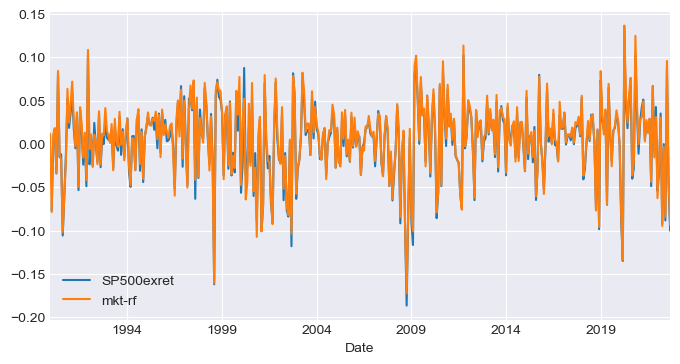

In [20]:
# Comparing SP500 excess returns to FF excess returns to check alignment
df_sp_500_exrets[['SP500exret', 'mkt-rf']].plot();

#### SP100 data manipulation

In [21]:
# End of month data but recorded in Python using first day of month
df_sp_100_adj_close.head()

,SP100
Date,
1989-12-01,164.675003
1990-01-01,153.940002
1990-02-01,156.240005
1990-03-01,160.014999
1990-04-01,157.115005


In [22]:
# Correcting data so day of month is business end of month
df_sp_100_adj_close.index = pd.to_datetime(df_sp_100_adj_close.index)
df_sp_100_adj_close = df_sp_100_adj_close.resample('BM').last()
df_sp_100_adj_close.head()

,SP100
Date,
1989-12-29,164.675003
1990-01-31,153.940002
1990-02-28,156.240005
1990-03-30,160.014999
1990-04-30,157.115005


In [23]:
# Calculating returns dataframe
df_sp_100_rets = np.log(df_sp_100_adj_close/df_sp_100_adj_close.shift(1))
df_sp_100_rets.head()

,SP100
Date,
1989-12-29,NaN
1990-01-31,-0.067411
1990-02-28,0.014830
1990-03-30,0.023874
1990-04-30,-0.018290


#### SP100 constituents data manipulation

In [24]:
# End of month data but recorded in Python using first day of month
df_sp100_constituents_data.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-01,0.250664,NaN,1.830009,NaN,1.188340,105.828514,0.765221,NaN,NaN,NaN,...,0.310161,3.211169,NaN,0.872812,NaN,5.769442,1.684878,1.127023,3.515244,4.134919
1990-01-01,0.241775,NaN,1.749273,NaN,1.379061,95.194878,0.730083,NaN,NaN,NaN,...,0.236618,3.141626,NaN,0.761773,NaN,5.069331,1.491162,1.039366,3.343113,3.886824
1990-02-01,0.241775,NaN,1.734571,NaN,1.779085,99.161308,0.897964,NaN,NaN,NaN,...,0.239815,3.210266,NaN,0.761773,NaN,4.706444,1.464131,0.986440,3.450956,3.886824
1990-03-01,0.287141,NaN,1.778528,NaN,2.234883,95.194878,0.964335,NaN,NaN,NaN,...,0.249408,3.062424,NaN,0.771796,NaN,4.942092,1.539057,0.999087,3.705856,3.873216
1990-04-01,0.280900,NaN,1.805578,NaN,2.253144,91.085503,0.999473,NaN,NaN,NaN,...,0.274988,2.894433,NaN,0.812125,NaN,4.896273,1.520950,0.910560,3.897904,3.789472


In [25]:
# Correcting data so day of month is business end of month
df_sp100_constituents_data.index = pd.to_datetime(df_sp100_constituents_data.index)
df_sp100_constituents_data = df_sp100_constituents_data.resample('BM').last()
df_sp100_constituents_data.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-29,0.250664,NaN,1.830009,NaN,1.188340,105.828514,0.765221,NaN,NaN,NaN,...,0.310161,3.211169,NaN,0.872812,NaN,5.769442,1.684878,1.127023,3.515244,4.134919
1990-01-31,0.241775,NaN,1.749273,NaN,1.379061,95.194878,0.730083,NaN,NaN,NaN,...,0.236618,3.141626,NaN,0.761773,NaN,5.069331,1.491162,1.039366,3.343113,3.886824
1990-02-28,0.241775,NaN,1.734571,NaN,1.779085,99.161308,0.897964,NaN,NaN,NaN,...,0.239815,3.210266,NaN,0.761773,NaN,4.706444,1.464131,0.986440,3.450956,3.886824
1990-03-30,0.287141,NaN,1.778528,NaN,2.234883,95.194878,0.964335,NaN,NaN,NaN,...,0.249408,3.062424,NaN,0.771796,NaN,4.942092,1.539057,0.999087,3.705856,3.873216
1990-04-30,0.280900,NaN,1.805578,NaN,2.253144,91.085503,0.999473,NaN,NaN,NaN,...,0.274988,2.894433,NaN,0.812125,NaN,4.896273,1.520950,0.910560,3.897904,3.789472


In [26]:
# Calculating returns dataframe
df_sp100_constituents_rets = np.log(df_sp100_constituents_data/df_sp100_constituents_data.shift(1))
df_sp100_constituents_rets.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31,-0.036106,NaN,-0.045121,NaN,0.148846,-0.105894,-0.047006,NaN,NaN,NaN,...,-0.270643,-0.021895,NaN,-0.136072,NaN,-0.129367,-0.122138,-0.080969,-0.050206,-0.061875
1990-02-28,0.000000,NaN,-0.008440,NaN,0.254696,0.040822,0.206971,NaN,NaN,NaN,...,0.013422,0.021613,NaN,0.000000,NaN,-0.074276,-0.018293,-0.052263,0.031749,0.000000
1990-03-30,0.171968,NaN,0.025026,NaN,0.228090,-0.040822,0.071309,NaN,NaN,NaN,...,0.039221,-0.047147,NaN,0.013073,NaN,0.048856,0.049908,0.012739,0.071263,-0.003507
1990-04-30,-0.021978,NaN,0.015095,NaN,0.008138,-0.044127,0.035789,NaN,NaN,NaN,...,0.097638,-0.056418,NaN,0.050933,NaN,-0.009315,-0.011835,-0.092782,0.050525,-0.021859


In [27]:
# Merge 5 factor FF data and SP100 returns
df_sp_100_exrets = pd.merge(df_sp_100_rets,df_ff_5f, left_index = True, right_index = True)
df_sp_100_exrets = pd.merge(df_sp100_constituents_rets,df_sp_100_exrets, left_index = True, right_index = True)

# SP100 Excess Returns Calculation - 5 factor model
df_sp_100_exrets['SP100exret'] = df_sp_100_exrets['SP100'] - df_sp_100_exrets['rf']

display(df_sp_100_exrets)

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,WMT,XOM,SP100,mkt-rf,smb,hml,rmw,cma,rf,SP100exret
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0116,-0.0227,0.0016,-0.0007,0.0142,0.0061,NaN
1990-01-31,-0.036106,NaN,-0.045121,NaN,0.148846,-0.105894,-0.047006,NaN,NaN,NaN,...,-0.050206,-0.061875,-0.067411,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.073111
1990-02-28,0.000000,NaN,-0.008440,NaN,0.254696,0.040822,0.206971,NaN,NaN,NaN,...,0.031749,0.000000,0.014830,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,0.009130
1990-03-30,0.171968,NaN,0.025026,NaN,0.228090,-0.040822,0.071309,NaN,NaN,NaN,...,0.071263,-0.003507,0.023874,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.017474
1990-04-30,-0.021978,NaN,0.015095,NaN,0.008138,-0.044127,0.035789,NaN,NaN,NaN,...,0.050525,-0.021859,-0.018290,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,-0.025190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,-0.057505,0.011794,0.038273,-0.003373,0.050550,0.002901,0.096210,0.066136,-0.033313,0.045384,...,-0.173432,0.118760,-0.004244,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0003,-0.004544
2022-06-30,-0.083469,0.038537,-0.077966,-0.072275,-0.129041,-0.137728,-0.045766,-0.002111,-0.123818,-0.177435,...,-0.052739,-0.104005,-0.081218,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0006,-0.081818
2022-07-29,0.172804,-0.065078,0.001747,0.098073,0.113653,0.018610,0.016994,0.063858,0.239486,0.105602,...,0.082608,0.123837,0.088660,0.0957,0.0188,-0.0410,0.0068,-0.0694,0.0008,0.087860


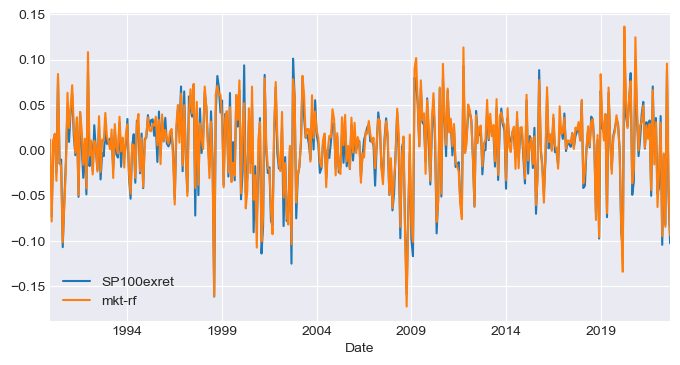

In [28]:
# Comparing SP100 excess returns to FF excess returns to check alignment
df_sp_100_exrets[['SP100exret', 'mkt-rf']].plot();

## Question 1

### 1 Factor Model (Example)

_First pass regression:_ Regress excess return of each SP500 constituent against SP500 excess returns to find SP500 constituent alpha and betas

In [29]:
# Initialise betas and mean returns
beta = np.zeros(N)
mean = np.zeros(N)

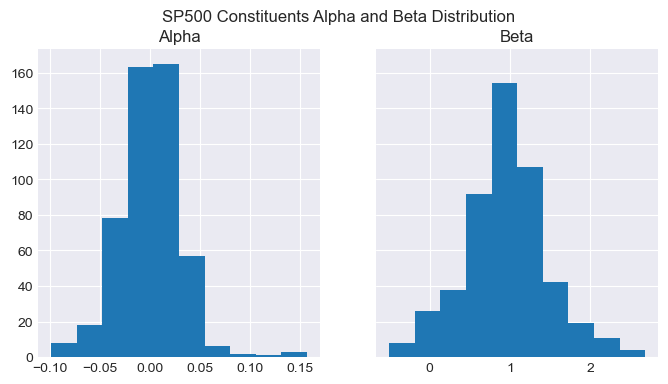

,alpha,beta
A,0.020080,1.041392
AAL,-0.018265,1.161359
AAP,-0.010312,0.909627
AAPL,0.014803,1.385097
ABBV,-0.008420,0.123461
...,...,...
YUM,-0.002976,0.550420
ZBH,-0.003815,0.691079
ZBRA,-0.020473,1.556886
ZION,-0.022678,0.782443


In [30]:
df_sp_500_exrets.dropna(axis=1, inplace = True, how='all')

x = df_sp_500_exrets['SP500exret']

stocks_array = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                     df_sp_500_exrets.columns.get_loc('ZTS')+1].values
rf_array = df_sp_500_exrets.loc[:,'rf'].values
rf_array = rf_array[:,np.newaxis]

y = stocks_array - rf_array # Array containing dependent variables in each column

X = sm.add_constant(x)
ts_res = sm.OLS(y, X, missing='drop').fit()
alpha = ts_res.params[0]
beta = ts_res.params[1:]

# Isolate alpha and beta
alpha = ts_res.params.iloc[0,:].values
beta = ts_res.params.iloc[1,:].values

# Plot Histogram of Alphas and Beta
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
axs[0].hist(alpha)
axs[0].set_title('Alpha')
axs[1].hist(beta)
axs[1].set_title('Beta')
plt.suptitle('SP500 Constituents Alpha and Beta Distribution')
plt.show()

# Format parameter datframe
ts_res.params = ts_res.params.rename(index={'const': 'alpha', 'SP500exret': 'beta'})
ts_res.params.columns = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                     df_sp_500_exrets.columns.get_loc('ZTS')+1].columns.values.tolist()
display(ts_res.params.T)

__CAPM Commentary__

Betas should not be negative. This is probably caused by noise. One could shrink these beta towards their average using Bayesian statistics.

_Second pass regression:_ Regress mean excess return of each SP500 constituent against SP100 constituent betas found in first pass regression

In [31]:
mean_exrets = np.nanmean(y, axis = 0)
mean_exrets = mean_exrets[:,np.newaxis]
print(mean_exrets.shape)

beta = beta[:,np.newaxis]
print(beta.shape)

(501, 1)
(501, 1)


In [32]:
ts_beta_mean = np.hstack((beta, mean_exrets))    
df_fm = pd.DataFrame(ts_beta_mean, index = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                                          df_sp_500_exrets.columns.get_loc('ZTS')+1].columns,
                    columns=['beta_capm', 'mean_exrets'])

# Second pass regression for returns
modelCS = sm.OLS.from_formula('mean_exrets ~ beta_capm', data=df_fm).fit()
print(modelCS.summary())
print('------------------------------------')
print('Annualised intercept', modelCS.params[0]*12)
print('Annualised risk premium', modelCS.params[1]*12)
print('Adj R-squared-adj', modelCS.rsquared_adj)
df_fm

                            OLS Regression Results                            
Dep. Variable:            mean_exrets   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     10.22
Date:                Mon, 05 Dec 2022   Prob (F-statistic):            0.00148
Time:                        21:45:26   Log-Likelihood:                 1820.6
No. Observations:                 501   AIC:                            -3637.
Df Residuals:                     499   BIC:                            -3629.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0066      0.001     10.821      0.0

,beta_capm,mean_exrets
A,1.041392,0.002226
AAL,1.161359,-0.004121
AAP,0.909627,0.008409
AAPL,1.385097,0.013982
ABBV,0.123461,0.014070
...,...,...
YUM,0.550420,0.009588
ZBH,0.691079,0.004813
ZBRA,1.556886,0.009424
ZION,0.782443,0.006343


### 3 Factor Model

In [33]:
x_3fm = df_sp_500_exrets.loc[:,['SP500exret', 'smb', 'hml']] 

X_3fm = sm.add_constant(x_3fm)
ts_res_3fm = sm.OLS(y, X_3fm, missing='drop').fit()

alpha_3fm = ts_res_3fm.params[0]
betas_3fm = ts_res_3fm.params[1:]
betas_3fm.shape

(3, 501)

In [34]:
ts_beta_mean_3fm = np.hstack((betas_3fm.T, mean_exrets))
df_3fm = pd.DataFrame(ts_beta_mean_3fm, index = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                                          df_sp_500_exrets.columns.get_loc('ZTS')+1].columns,
                    columns=['beta_capm', 'beta_size', 'beta_val', 'mean_exrets'])

# Second pass regression for returns
modelCS_3fm = sm.OLS.from_formula('mean_exrets ~ beta_capm + beta_size + beta_val', data=df_3fm).fit()
print(modelCS_3fm.summary())
print('------------------------------------------------------------------------------')
print('Annualised intercept', modelCS_3fm.params[0]*12)
print('Annualised risk premium', modelCS_3fm.params[1]*12)
print('Annualised size premium', modelCS_3fm.params[2]*12)
print('Annualised value premium', modelCS_3fm.params[3]*12)
print('Adj R-squared-adj', modelCS_3fm.rsquared_adj)

                            OLS Regression Results                            
Dep. Variable:            mean_exrets   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     23.18
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           4.64e-14
Time:                        21:45:26   Log-Likelihood:                 1848.4
No. Observations:                 501   AIC:                            -3689.
Df Residuals:                     497   BIC:                            -3672.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0071      0.001     12.046      0.0

#### Analysis

Fama and French propose a three-factor model in which the random return on each individual asset j = 1,2,...,n is governed by 
$$ \tilde{r}_{j} = \alpha_{j} + \beta_{j,m}[\tilde{r}_{M} - E(\tilde{r}_{M})] + \beta_{j,s}[\tilde{r}_{SMB} - E(\tilde{r}_{SMB})] + \beta_{j,h}[\tilde{r}_{HML} - E(\tilde{r}_{HML})] + \epsilon_{j}$$

where $\tilde{r}_{SMB}$ is the return on the “small-minus-big” portfolio, $\tilde{r}_{HML}$ is the return on the “high-minus-low” book-to-market value portfolio, $\beta_{j,m}$, $\beta_{j,s}$ and $\beta_{j,h}$ measure the exposure (correlation) of the return on asset j to the market, company size and equity valuation relative to book value.

Our three factor model is as follows:
$$ \tilde{r}_{j} = 0.085 + 0.024[\tilde{r}_{M} - E(\tilde{r}_{M})] + 0.004[\tilde{r}_{SMB} - E(\tilde{r}_{SMB})] - 0.040[\tilde{r}_{HML} - E(\tilde{r}_{HML})]$$

The intercept indicates the expected return of a stock j in the S&P500 before the effect of the factors are taken into account. At 8.5%, this is the near the typical level of annualised return we would expect on the S&P over the long run. 

<br>

_Factors + Coefficients_

 - $0.024[\tilde{r}_{M} - E(\tilde{r}_{M})]$:__Market risk premium__. This is the expected return on the asset stemming from the overall level of risk in the market. Here, a positive coefficient indicates that the returns will increase when the market goes up and vice versa when the market goes down, assuming $\beta_{M}$ is positive, the amount by which depending on the magnitude of $\beta_{M}$. 
 - $0.004[\tilde{r}_{SMB} - E(\tilde{r}_{SMB})]$: __Size premium__.This is the additional return that investors can expect to earn on assets that are smaller in size compared to the overall market, as smaller assets tend to be less liquid and more risky. While the effect of this factor is minimal, this indicates that smaller firms do indeed generate a minor excess return.
 - $-0.040[\tilde{r}_{HML} - E(\tilde{r}_{HML})]$: __Value premium__.This is the additional return that investors can expect to earn on assets that are considered to be undervalued compared to the overall market. A negative coefficient here indicates that the portfolio behaves more like a growth stock portfolio, as it has a negative relationship with an exposure to ‘value’ stocks. Although historically value has outperformed, from the GFC until more recently, growth stocks have fared better than value stocks globally. 
 - Overall, this model suggests that the return on each asset is being driven primarily by its level of $\alpha$, or expected return, with stocks that are smaller cap and growth oriented offering the potential for additional returns. Value stocks do not appear to drive additional returns, however, despite their historical outperformance, an interesting finding.
 
<br>

_Model Suitability_

 - __R-squared:__ Only 12.3% of the variability in the returns of the S&P can be explained by the factor variables. This is far too weak a relationship to infer any meaningful results from.
 - __Adjusted R-squared:__ As the adjusted R-squared of 11.7% is lower than the original, we can conclude that adding an additional variable will not add to the explanatory power of the model.
 - __Prob(F-statistic):__ As the probability is close to zero, the overall the regressions is somewhat meaningful.
 - __Prob(Omnibus):__ OLS assumption that the errors are normally distributed is not satisfied. Therefore, coefficients estimated out of it are not Best Linear Unbiased Estimators (BLUE), and following on from this, the high Jarque-Bera test result indicates the errors are not normally distributed.
 - __Durbin-Watson:__ REDO

### 5 Factor Model

In [35]:
x_5fm = df_sp_500_exrets.loc[:,['SP500exret', 'smb', 'hml', 'rmw', 'cma']] 

X_5fm = sm.add_constant(x_5fm)
ts_res_5fm = sm.OLS(y, X_5fm, missing='drop').fit()

alpha_5fm = ts_res_5fm.params[0]
betas_5fm = ts_res_5fm.params[1:]
betas_5fm.shape

(5, 501)

In [36]:
ts_beta_mean_5fm = np.hstack((betas_5fm.T, mean_exrets))
df_5fm = pd.DataFrame(ts_beta_mean_5fm, index = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                                          df_sp_500_exrets.columns.get_loc('ZTS')+1].columns,
                    columns=['beta_capm', 'beta_size', 'beta_val','beta_prof','beta_inv', 'mean_exrets'])

# Second pass regression for returns
modelCS_5fm = sm.OLS.from_formula('mean_exrets ~ beta_capm + beta_size + beta_val + beta_prof + beta_inv', 
                                  data=df_5fm).fit()
print(modelCS_5fm.summary())
print('------------------------------------------------------------------------------')
print('Annualised intercept', modelCS_5fm.params[0]*12)
print('Annualised risk premium', modelCS_5fm.params[1]*12)
print('Annualised size premium', modelCS_5fm.params[2]*12)
print('Annualised value premium', modelCS_5fm.params[3]*12)
print('Annualised profitability premium', modelCS_5fm.params[4]*12)
print('Annualised investment premium', modelCS_5fm.params[5]*12)
print('Adj R-squared-adj', modelCS_5fm.rsquared_adj)

                            OLS Regression Results                            
Dep. Variable:            mean_exrets   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     15.90
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           1.56e-14
Time:                        21:45:26   Log-Likelihood:                 1852.9
No. Observations:                 501   AIC:                            -3694.
Df Residuals:                     495   BIC:                            -3668.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0073      0.001     12.065      0.0

#### Analysis

WRITE UP

## Question 2

In [ ]:
### MM to insert code

### Question 2 Commentary
xxxx

## Question 3

#### SP100 constituents returns data manipulation

In [41]:
print(df_sp100_constituents_rets.isna().sum()) # Check number of missing values across columns
print('Number of missing values across entire dataframe:', 
      df_sp100_constituents_rets.isna().sum().sum()) # Check number of missing values across entire dataframe

AAPL      1
ABBV    279
ABT       1
ACN     141
ADBE      1
       ... 
VZ        1
WBA       1
WFC       1
WMT       1
XOM       1
Length: 101, dtype: int64
Number of missing values across entire dataframe: 6094


In [42]:
df_sp100_constituents_rets = df_sp100_constituents_rets.loc['2005-01-01':'2022-09-30'] # redefine date range
df_sp100_constituents_rets_new = df_sp100_constituents_rets.dropna(axis=1) # Drops columns that contain Nan values

# Drop AIG as it went bankrupt in 2008 and was bailed out, Google has two classes of shares so remove one
df_sp100_constituents_rets_new = df_sp100_constituents_rets_new.drop(['AIG', 'GOOGL'], axis=1) 

# Find dropped constituents from dropna function
df_sp100_constituents_list = df_sp100_constituents_rets.columns.tolist() 
df_sp100_constituents_new_list = df_sp100_constituents_rets_new.columns.tolist()
dropped_constituents = list(set(df_sp100_constituents_list) - set(df_sp100_constituents_new_list))

print('Number of missing values across entire dataframe:', 
      df_sp100_constituents_rets_new.isna().sum().sum()) # Check number of missing values across entire dataframe
print(f'Number of dropped companies: {len(dropped_constituents)}')
print('Companies dropped:', *dropped_constituents)

Number of missing values across entire dataframe: 0
Number of dropped companies: 16
Companies dropped: KHC TSLA PYPL CHTR GM BRK.B AIG FB TMUS V GOOGL AVGO MA DOW PM ABBV


#### Windsorize returns data

In [43]:
# Make a copy to compare between original returns data and windsorized returns data
df_sp100_constituents_rets_winz = df_sp100_constituents_rets_new.copy()

In [44]:
# Apply function - Windsorize 0 - 2nd percentile and 95th to 100th percentile (stock returns are negatively skewed)
windsorize_ret(df_sp100_constituents_rets_winz, df_sp100_constituents_rets_winz.columns, 0.02, 0.05)

In [45]:
# Compare original returns data and windsorized returns data 
returns_describe(df_sp100_constituents_rets_new, 'Original Stock')
returns_describe(df_sp100_constituents_rets_winz, 'Windsorized Stock')

**Original Stock Returns Characteristics**

,AAPL,ABT,ACN,ADBE,AMGN,AMT,AMZN,AXP,BA,BAC,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,...,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,0.023225,0.008842,0.012029,0.010197,0.007221,0.012460,0.018462,0.005982,0.005663,-0.000248,...,0.010393,0.012353,0.013160,0.005337,0.003666,0.004160,0.000869,0.003533,0.005999,0.005264
std,0.093145,0.052786,0.062252,0.089090,0.069002,0.058729,0.102470,0.088721,0.095973,0.125193,...,0.069483,0.072590,0.069335,0.067742,0.072514,0.050997,0.077398,0.089295,0.049911,0.065762
min,-0.399818,-0.171030,-0.159084,-0.393127,-0.173707,-0.170691,-0.363568,-0.318729,-0.606353,-0.738200,...,-0.222478,-0.365844,-0.288431,-0.260970,-0.504269,-0.129484,-0.209026,-0.445957,-0.173432,-0.289365
25%,-0.031422,-0.023501,-0.025784,-0.043022,-0.036845,-0.020910,-0.044353,-0.024559,-0.043458,-0.045554,...,-0.033443,-0.027902,-0.020232,-0.024094,-0.028342,-0.023138,-0.047104,-0.031822,-0.022925,-0.031114
50%,0.036014,0.011393,0.019056,0.025225,0.007499,0.011523,0.022708,0.011684,0.014721,0.002906,...,0.012980,0.020032,0.017555,0.010135,0.011413,0.003406,-0.001568,0.011744,0.004655,0.006989
75%,0.085444,0.042997,0.051039,0.060796,0.041740,0.051708,0.078880,0.046550,0.062660,0.063499,...,0.057041,0.057950,0.052832,0.041503,0.041737,0.041743,0.044993,0.041531,0.038195,0.043339
max,0.213256,0.154459,0.149221,0.247515,0.283698,0.155212,0.432653,0.615364,0.377965,0.546144,...,0.164645,0.235912,0.208290,0.250014,0.223819,0.141848,0.231135,0.340177,0.137816,0.216223
skew,-0.878983,-0.368359,-0.365038,-0.875401,0.455985,-0.293282,-0.072057,0.846244,-1.306954,-1.141074,...,-0.341563,-1.250274,-0.450912,-0.442774,-2.024041,-0.186725,0.116532,-0.978902,-0.429758,-0.216012
kurt,5.447698,3.678531,3.025276,5.552921,4.691330,3.509113,5.060638,14.537510,11.495916,11.328030,...,3.107271,8.196375,4.519695,5.329459,15.070434,2.913673,3.455228,10.081136,4.306323,5.449200


**Windsorized Stock Returns Characteristics**

,AAPL,ABT,ACN,ADBE,AMGN,AMT,AMZN,AXP,BA,BAC,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,...,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,0.024696,0.008382,0.011413,0.010248,0.005427,0.011699,0.016491,0.002131,0.005267,-0.002045,...,0.010017,0.013567,0.012754,0.003591,0.004488,0.003204,-0.000968,0.003417,0.006248,0.003825
std,0.083349,0.049548,0.059691,0.078279,0.062027,0.055462,0.090921,0.070967,0.078731,0.101726,...,0.066440,0.059911,0.063222,0.060859,0.059503,0.048375,0.071301,0.067250,0.045410,0.056337
min,-0.155589,-0.119083,-0.131950,-0.193733,-0.139731,-0.136180,-0.225887,-0.228414,-0.226009,-0.350426,...,-0.144140,-0.135202,-0.136235,-0.175278,-0.173981,-0.113184,-0.166422,-0.163389,-0.106164,-0.131823
25%,-0.031422,-0.023501,-0.025784,-0.043022,-0.036845,-0.020910,-0.044353,-0.024559,-0.043458,-0.045554,...,-0.033443,-0.027902,-0.020232,-0.024094,-0.028342,-0.023138,-0.047104,-0.031822,-0.022925,-0.031114
50%,0.036014,0.011393,0.019056,0.025225,0.007499,0.011523,0.022708,0.011684,0.014721,0.002906,...,0.012980,0.020032,0.017555,0.010135,0.011413,0.003406,-0.001568,0.011744,0.004655,0.006989
75%,0.085444,0.042997,0.051039,0.060796,0.041740,0.051708,0.078880,0.046550,0.062660,0.063499,...,0.057041,0.057950,0.052832,0.041503,0.041737,0.041743,0.044993,0.041531,0.038195,0.043339
max,0.163508,0.090155,0.112743,0.130960,0.122802,0.104634,0.183102,0.109081,0.131950,0.163381,...,0.121428,0.113285,0.124424,0.106405,0.103793,0.079070,0.126996,0.131238,0.088808,0.099082
skew,-0.280161,-0.398690,-0.449356,-0.576497,-0.058415,-0.376962,-0.357570,-1.172080,-0.692693,-1.064835,...,-0.329165,-0.465410,-0.371868,-0.839887,-0.728735,-0.352132,-0.170538,-0.416794,-0.146337,-0.369606
kurt,2.343746,2.955783,2.725938,2.808534,2.692626,2.997900,3.080971,4.877458,3.528251,5.098002,...,2.614986,2.872249,2.811387,4.067033,3.796315,2.568995,2.655487,3.238372,2.686286,2.785200


#### SP100, SP100 constituents dataframe and 5 factor FF dataframes

In [46]:
# Merge 5 factor FF data and SP100 returns
df_sp_100_exrets = pd.merge(df_sp_100_rets,df_ff_5f, left_index = True, right_index = True)

# SP100 Excess Returns Calculation - 5 factor model
df_sp_100_exrets['SP100exret'] = df_sp_100_exrets['SP100'] - df_sp_100_exrets['rf']

# Merge windsorized SP100 constituents dataframe to SP100 and FF data
df_sp_100_exrets_new = pd.merge(df_sp100_constituents_rets_winz,df_sp_100_exrets, left_index = True, right_index = True)

display(df_sp_100_exrets_new.head())

,AAPL,ABT,ACN,ADBE,AMGN,AMT,AMZN,AXP,BA,BAC,...,WMT,XOM,SP100,mkt-rf,smb,hml,rmw,cma,rf,SP100exret
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.163508,-0.035567,-0.035819,-0.097494,-0.030226,-0.015335,-0.024456,-0.055063,-0.022859,-0.003509,...,-0.005551,0.006611,-0.018261,-0.0276,-0.0118,0.0206,0.0273,-0.0146,0.0016,-0.019861
2005-02-28,0.154188,0.026855,-0.019380,0.081799,-0.010174,0.011523,-0.205826,0.017065,0.082836,0.006020,...,-0.015191,0.099082,0.016730,0.0189,-0.0030,0.0153,0.0145,-0.0005,0.0016,0.015130
2005-03-31,-0.073765,0.013606,-0.056353,0.084133,-0.056767,-0.005471,-0.026207,-0.052703,0.066239,-0.056213,...,-0.029494,-0.055502,-0.022144,-0.0197,-0.0142,0.0204,0.0047,0.0129,0.0021,-0.024244
2005-04-29,-0.144598,0.053050,-0.106972,-0.121559,0.000000,-0.056416,-0.057347,0.027921,0.017970,0.030695,...,-0.058155,-0.044078,-0.016312,-0.0261,-0.0398,0.0006,0.0097,-0.0094,0.0021,-0.018412
2005-05-31,0.097677,-0.013134,0.070282,0.107812,0.072388,0.045939,0.092891,0.021587,0.071007,0.028023,...,0.001908,-0.014660,0.021035,0.0365,0.0279,-0.0064,-0.0100,0.0030,0.0024,0.018635


In [47]:
rets_all = df_sp_100_exrets_new.loc[:,'AAPL':'XOM'].values

# List of stocks used
SP100_list = df_sp_100_exrets_new.loc[:,'AAPL':'XOM'].columns.values.tolist()

#### Set in-sample and out-of-sample period
Set the oldest five years of data [1;m] as the initial in-sample period. 
Data starts at 2005-01-31 so use 2009-12-31 as split date.

In [48]:
is_end_date = datetime(2009,12,31)
os_start_date = datetime(2010,1,31)

# In Sample period
df_is = df_sp_100_exrets_new.loc[:is_end_date,'AAPL':'XOM']
dates_is = df_is.index

# rets is set to a numpy array
rets_is = df_is.values
T_in = len(rets_is)
print(f'Number of Months in In-Sample Observations: {T_in}', '\n')
display(Markdown("**In-Sample Dataframe**"))
display(df_is.head())

# Out-of-Sample period
df_os = df_sp_100_exrets_new.loc[os_start_date:,'AAPL':'XOM']
dates_os = df_os.index
T_os = len(dates_os)
display(Markdown("**Out-of-Sample Dataframe**"))
display(df_os.head())

Number of Months in In-Sample Observations: 60 



**In-Sample Dataframe**

,AAPL,ABT,ACN,ADBE,AMGN,AMT,AMZN,AXP,BA,BAC,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.163508,-0.035567,-0.035819,-0.097494,-0.030226,-0.015335,-0.024456,-0.055063,-0.022859,-0.003509,...,-0.058976,0.009834,-0.116049,-0.134836,-0.031834,-0.113184,0.104813,-0.013771,-0.005551,0.006611
2005-02-28,0.154188,0.026855,-0.019380,0.081799,-0.010174,0.011523,-0.205826,0.017065,0.082836,0.006020,...,0.121428,0.025104,0.062597,0.036936,-0.010033,0.020287,0.005150,-0.031822,-0.015191,0.099082
2005-03-31,-0.073765,0.013606,-0.056353,0.084133,-0.056767,-0.005471,-0.026207,-0.052703,0.066239,-0.056213,...,-0.037726,0.045253,0.093948,-0.059064,-0.031760,-0.013152,0.037703,0.014845,-0.029494,-0.055502
2005-04-29,-0.144598,0.053050,-0.106972,-0.121559,0.000000,-0.056416,-0.057347,0.027921,0.017970,0.030695,...,-0.021012,-0.008841,-0.081758,-0.019855,-0.021842,0.008415,-0.031096,0.002338,-0.058155,-0.044078
2005-05-31,0.097677,-0.013134,0.070282,0.107812,0.072388,0.045939,0.092891,0.021587,0.071007,0.028023,...,0.103001,0.027653,0.046307,0.032288,0.049984,-0.000414,0.051596,0.007811,0.001908,-0.014660


**Out-of-Sample Dataframe**

,AAPL,ABT,ACN,ADBE,AMGN,AMT,AMZN,AXP,BA,BAC,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-26,0.063347,0.032273,-0.025199,0.070231,-0.032500,0.004935,-0.057520,0.018323,0.041376,0.093032,...,0.085361,0.025727,0.107556,0.016651,-0.018918,-0.002446,-0.022725,-0.039094,0.011907,0.008808
2010-03-31,0.138431,-0.029920,0.048350,0.020566,0.055489,-0.001173,0.136894,0.077319,0.131950,0.068993,...,0.003685,-0.035777,0.088436,0.100418,0.050318,0.069753,0.055295,0.131238,0.027904,0.036509
2010-04-30,0.105280,-0.029278,0.039495,-0.051338,-0.043199,-0.043162,0.009748,0.109081,-0.002482,-0.000513,...,0.061033,-0.074980,0.031689,0.070864,0.035733,-0.070791,-0.053723,0.061985,-0.030267,0.011725
2010-05-31,-0.016257,-0.064577,-0.131950,-0.046293,-0.101471,-0.006885,-0.088724,-0.145623,-0.120929,-0.124677,...,-0.058547,-0.040852,-0.057532,-0.096815,-0.110897,-0.033587,-0.092639,-0.143287,-0.059135,-0.114138
2010-06-30,-0.021046,-0.016536,0.029672,-0.193733,0.015712,0.093447,-0.138257,-0.004273,-0.016746,-0.091062,...,-0.047808,-0.023318,-0.022423,-0.091286,-0.069559,0.018005,-0.166422,-0.112437,-0.044710,-0.050935


In [49]:
# In-sample expected returns vector and standard deviation vector
mu_1d = rets_is.mean(0) 
sigma = rets_is.std(0) 
N = len(mu_1d) # Number of assets

In [50]:
returns_describe(df_is, 'In-Sample Stock')

**In-Sample Stock Returns Characteristics**

,AAPL,ABT,ACN,ADBE,AMGN,AMT,AMZN,AXP,BA,BAC,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.036812,0.005465,0.008153,0.003368,-0.007704,0.011857,0.014707,-0.012647,0.003444,-0.017704,...,0.002796,0.001163,0.013817,-0.004478,0.000651,0.000393,-0.000358,0.000187,0.002131,0.004439
std,0.098813,0.050254,0.059430,0.093154,0.066450,0.065111,0.114427,0.082697,0.082976,0.125054,...,0.078617,0.074624,0.072475,0.060480,0.063611,0.050568,0.070859,0.071699,0.044363,0.052306
min,-0.155589,-0.119083,-0.131950,-0.193733,-0.139731,-0.136180,-0.225887,-0.228414,-0.226009,-0.350426,...,-0.144140,-0.135202,-0.136235,-0.175278,-0.173981,-0.113184,-0.166422,-0.163389,-0.106164,-0.123821
25%,-0.045054,-0.029278,-0.032575,-0.082321,-0.051684,-0.025446,-0.047488,-0.041943,-0.045513,-0.043259,...,-0.037495,-0.051688,-0.031708,-0.029835,-0.031779,-0.030881,-0.035052,-0.032456,-0.022849,-0.028426
50%,0.056387,0.014378,0.014002,0.022343,-0.006529,0.013058,0.020001,0.003080,0.009013,-0.003624,...,-0.004664,0.012296,0.015367,-0.000413,0.001004,0.004099,0.007525,0.003128,0.001494,0.006727
75%,0.117190,0.033299,0.046647,0.065275,0.035943,0.055630,0.103317,0.032663,0.068900,0.040657,...,0.069506,0.061667,0.068478,0.032601,0.040307,0.042872,0.044670,0.027857,0.026883,0.040467
max,0.163508,0.090155,0.112743,0.130960,0.122802,0.104634,0.183102,0.109081,0.131950,0.163381,...,0.121428,0.113285,0.124424,0.106405,0.103793,0.079070,0.126996,0.131238,0.088808,0.099082
skew,-0.486840,-0.488388,-0.199096,-0.508890,0.145433,-0.426105,-0.448023,-1.030407,-0.816155,-1.295007,...,-0.184913,-0.394359,-0.255253,-1.175722,-0.769237,-0.448341,-0.463325,-0.256998,-0.065321,-0.273146
kurt,2.122958,3.232281,2.480554,2.263546,2.677715,2.654109,2.529216,4.075904,3.821252,5.178471,...,2.146876,2.216239,2.328741,4.910531,4.157354,2.632663,2.958613,3.564765,2.954282,2.986787


In [51]:
# Covariance matrix using the numpy array rets (can also estimate covariance of the columns in a dataframe)
Sigma = np.cov(rets_is.T) # Must transpose array as default is to estimate covariance along rows rather than down columns 
print(Sigma.shape)

(85, 85)


In [52]:
# Set up a column unit vector
ell = np.ones((N,1))

In [53]:
# Convert 1d array to 2d array (column vector) so that we can use matrix algebra in optimal weights computation
mu = mu_1d[:, np.newaxis] 

### Global Minimum Variance Portfolio (GMVP)
_Weights of GMVP:_
$$w_{t}^{(GMVP)} = (\frac{1}{C})\Sigma^{-1}\ell$$
where
$$C = \ell^{'}\Sigma^{-1}\ell$$

$\Sigma$ is assumed to be estimated using only information up to time _t_ (i.e. using in sample period data) 

_Realised scalar out-of-sample return of a portfolio is given by:_
$$r_{t+1} = w_{t}^{'} \times \mathbf{r}_{t+1}$$

#### In-Sample GMVP

In [54]:
# In-Sample GMVP
Sigma_inv_ell = np.linalg.solve(Sigma, ell)                  # Solving Sigma^{-1}*ell
C = np.dot(ell.T, Sigma_inv_ell)                             # Calculating C = ell'*Sigma^{-1}*ell
w_gmvp_is = (1/C)*Sigma_inv_ell                              # Calculating weights vector: w = (1/C)*Sigma^{-1}*ell
mu_gmvp_is = np.dot(mu.T, w_gmvp_is)                         # In-sample portfolio return
var_gmvp_is = np.dot(w_gmvp_is.T, np.dot(Sigma, w_gmvp_is))  # In-sample portfolio variance
# sigma_gmvp_is = np.sqrt(var_gmvp_is)                         # In-sample portfolio std dev (RUNTIME ERROR)

#### Out-of-Sample GMVP

In [55]:
# Out-of-Sample GMVP
w_mvp_os = np.zeros((N,T_os))
r_mvp_os = np.empty(T_os)
for i in range(T_os):
    Sigma_os = np.cov(rets_all[i:T_in+i,:].T)                 # Using [t1,t2] to estimate Sigma ([i,52+i], for i = 0, 1, ...)
    Sigma_inv_ell_os = np.linalg.solve(Sigma_os, ell)         # Storing Sigma^{-1}*ell
    C = np.dot(ell.T, Sigma_inv_ell_os)                       # Calculating C = ell'*Sigma^{-1}*ell
    w = (1/C)*Sigma_inv_ell_os                                # Calculating weights vector: w = (1/C)*Sigma^{-1}*ell
    w_mvp_os[:,i] = w.T                                       # Storing weights vector 
    r_mvp_os[i] = np.dot(rets_all[T_in+i,:], w_mvp_os[:,i])   # Out-of-sample portfolio returns

### Portfolio 2 
_Weights of Second Portfolio:_
$$w_{t}^{(2)} = a + BE_{t}[\tilde{r}_{t+1}]$$
where
$$a = \frac{\Sigma^{-1}\ell}{\ell^{'}\Sigma^{-1}\ell}$$
and
$$B = \frac{1}{\gamma}\left(\Sigma^{-1}-\frac{\Sigma^{-1}\ell\ell^{'}\Sigma^{-1}}{\ell^{'}\Sigma^{-1}\ell}\right)$$

 - $\Sigma$ is assumed to be estimated using only information up to time _t_ (i.e. using in sample period data)
 - $\gamma$ denotes the level of relative risk aversion
 - $E_{t}[\tilde{r}_{t+1}]$ is the vector of CAPM expected excess returns of the stocks estimated using information up to time _t_ (i.e. using in sample period data)
 
_Realised scalar out-of-sample return of a portfolio is given by:_
$$r_{t+1} = w_{t}^{'} \times \mathbf{r}_{t+1}$$



<br>Note: As gamma goes to infinity, weights in portfolio 2 approaches the GVMP

#### In-Sample Portfolio 2

_CAPM to calculate expected excess returns_

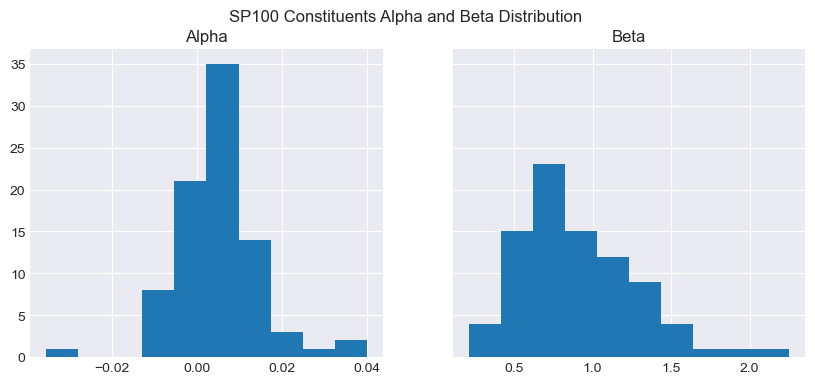

,AAPL,ABT,ACN,ADBE,AMGN,AMT,AMZN,AXP,BA,BAC,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
alpha,0.039867,0.004044,0.008884,0.006990,-0.008044,0.013052,0.016916,-0.008651,0.006514,-0.011586,...,0.004879,0.002157,0.015975,-0.003625,0.001848,0.000854,0.000249,0.001687,0.000730,0.004095
beta,1.281676,0.213377,0.727038,1.416986,0.471516,0.837913,1.079848,1.506252,1.285364,2.012905,...,1.049854,0.789691,1.067604,0.756060,0.838216,0.662748,0.697346,0.910589,0.218203,0.470458


In [56]:
# SP100 excess returns within in sample period
x = df_sp_100_exrets_new.loc[:is_end_date,'SP100exret']

# Calculate excess return of each stock during in sample period
stocks_array = df_sp_100_exrets_new.loc[:is_end_date,'AAPL':'XOM'].values 
rf_array = df_sp_100_exrets_new.loc[:is_end_date,'rf'].values
rf_array = rf_array[:,np.newaxis]
y = stocks_array - rf_array # Array containing dependent variables in each column

# OLS Regression
X = sm.add_constant(x)
ts_res = sm.OLS(y, X, missing='drop').fit()

# Isolate alpha and beta
alpha = ts_res.params.iloc[0,:].values
beta = ts_res.params.iloc[1,:].values

# Plot Histogram of Alphas and Beta
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))
axs[0].hist(alpha)
axs[0].set_title('Alpha')
axs[1].hist(beta)
axs[1].set_title('Beta')
plt.suptitle('SP100 Constituents Alpha and Beta Distribution')
plt.show()

# Format parameter datframe
ts_res.params = ts_res.params.rename(index={'const': 'alpha', 'SP100exret': 'beta'})
ts_res.params.columns = SP100_list
display(ts_res.params)

In [57]:
# Excess return of stock = alpha + beta*excess returns on market

# SP100 excess returns within in sample period
SP100_exret_is = df_sp_100_exrets_new.loc[:is_end_date,'SP100exret']

# Constant beta calculated over in sample period
beta_is = [beta for i in range(T_in)]

# Reorder SP500 excess return list to 2d array
SP100_exret_is = np.array(SP100_exret_is)
SP100_exret_is = SP100_exret_is[:, np.newaxis] 

# CAPM calculation - Alpha should be zero
exret_is = beta_is*SP100_exret_is
exret_df_is = pd.DataFrame(data=exret_is, columns=SP100_list, index=dates_is)
display(Markdown("**CAPM expected excess returns of Stocks over In-Sample Period**"))
display(exret_df_is.head())

**CAPM expected excess returns of Stocks over In-Sample Period**

,AAPL,ABT,ACN,ADBE,AMGN,AMT,AMZN,AXP,BA,BAC,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,-0.025455,-0.004238,-0.014440,-0.028143,-0.009365,-0.016642,-0.021447,-0.029916,-0.025528,-0.039978,...,-0.020851,-0.015684,-0.021204,-0.015016,-0.016648,-0.013163,-0.013850,-0.018085,-0.004334,-0.009344
2005-02-28,0.019392,0.003228,0.011000,0.021439,0.007134,0.012678,0.016338,0.022790,0.019448,0.030455,...,0.015884,0.011948,0.016153,0.011439,0.012682,0.010027,0.010551,0.013777,0.003301,0.007118
2005-03-31,-0.031073,-0.005173,-0.017626,-0.034353,-0.011431,-0.020314,-0.026180,-0.036518,-0.031162,-0.048801,...,-0.025453,-0.019145,-0.025883,-0.018330,-0.020322,-0.016068,-0.016906,-0.022076,-0.005290,-0.011406
2005-04-29,-0.023598,-0.003929,-0.013386,-0.026089,-0.008681,-0.015427,-0.019882,-0.027733,-0.023666,-0.037061,...,-0.019330,-0.014539,-0.019656,-0.013920,-0.015433,-0.012202,-0.012839,-0.016765,-0.004017,-0.008662
2005-05-31,0.023884,0.003976,0.013548,0.026405,0.008787,0.015614,0.020123,0.028069,0.023953,0.037510,...,0.019564,0.014716,0.019895,0.014089,0.015620,0.012350,0.012995,0.016969,0.004066,0.008767


_Calculate $BE_{t}[\tilde{r}_{t+1}]$_

Split $BE_{t}[\tilde{r}_{t+1}]$ into smaller more managable terms denoting $E_{t}[\tilde{r}_{t+1}]$ as $\mu$

First term is:

$$d = \frac{1}{\gamma}\left(\Sigma^{-1}\mu\right)$$

$$e = \frac{1}{\gamma}\left(\frac{F}{C}\right)\Sigma^{-1}\ell$$
$$F = \ell^{'}\Sigma^{-1}\mu$$ 
$$C = \ell^{'}\Sigma^{-1}\ell$$ 

($C$ as per defintion in GMVP)

Rewriting B to be a function of new variables

$$BE_{t}[\tilde{r}_{t+1}] = d - e$$

In [58]:
gamma = 3 # Reasonable level of risk aversion found in individual project

In [59]:
exret_is_mu_1d = exret_is.mean(0)
exret_is_mu = exret_is_mu_1d[:, np.newaxis]

In [60]:
# Solving Sigma^{-1}*mu
Sigma_inv_mu = np.linalg.solve(Sigma, exret_is_mu)

# Calculate d
d = (1/gamma)*(Sigma_inv_mu)

# Checking shape of array
d.shape

(85, 1)

In [61]:
# Calculating F = ell'*Sigma^{-1}*mu
F = np.dot(ell.T, Sigma_inv_mu)

# Calculate e = (1/gamma)*(F/C)*Sigma^{-1}*ell
e = (1/gamma)*(F/C)*(Sigma_inv_ell)

# Checking shape of array
e.shape

(85, 1)

In [62]:
#Define Bmu
Bmu = d - e

_$BE_{t}[\tilde{r}_{t+1}]$ properties_
 
 - As $w_{t}^{(GMVP)}$ always sums to one, one expects $BE_{t}[\tilde{r}_{t+1}]$ to sum to zero to ensure that $w_{t}^{(2)}$ will also sum to one
 - $\sum BE_{t}[\tilde{r}_{t+1}] \xrightarrow{n} 0$ for larger in sample periods

We need a finite sample correction step where we either:
 - Shift $BE_{t}[\tilde{r}_{t+1}]$ so that it sums to zero (Bmu -= Bmu.sum()/Bmu.size())
 - Scale $w_{t}^{(2)}$ so that is sums to one (w_p2 /= w_p2.sum())

Option 1 was chosen, because option 2 modifies GMVP

In [63]:
print(f"{Bmu.sum()=}")
Bmu -= Bmu.sum()/Bmu.size # Applying Correction
print(f"{Bmu.sum()=}")

Bmu.sum()=407156498163489.8
Bmu.sum()=0.09375


In [64]:
w_p2_is = w_gmvp_is + Bmu # Calculating weights vector: w = a + BE[r_{t}], recognising a as the weights under the GMVP
print('Sum of weights:', w_p2_is.sum())

Sum of weights: 1.1875


In [65]:
mu_p2_is = np.dot(mu.T, w_p2_is)                           # In-sample portfolio return
var_p2_is = np.dot(w_p2_is.T, np.dot(Sigma, w_p2_is))      # In-sample portfolio variance
sigma_p2_is = np.sqrt(var_p2_is)                           # In-sample portfolio std dev 

#### Out-of-Sample Portfolio 2

In [66]:
# Excess return of stock = alpha + beta*excess returns on market

# SP100 excess returns within out of sample period
SP100_exret_os = df_sp_100_exrets_new.loc[os_start_date:,'SP100exret']

# Constant beta calculated over in sample period applied to out of sample data
beta_os = [beta for i in range(T_os)]

# Reorder SP500 excess return list to 2d array
SP100_exret_os = np.array(SP100_exret_os)
SP100_exret_os = SP100_exret_os[:, np.newaxis] 

# CAPM calculation - Alpha should be zero
exret_os = beta_os*SP100_exret_os

In [67]:
exret_os_mu_1d = exret_os.mean(0)
exret_os_mu = exret_os_mu_1d[:, np.newaxis] 

In [68]:
# Out-of-Sample Port 2
w_p2_os = np.zeros((N,T_os))                                  # row=stock, column=time point
r_p2_os = np.empty(T_os)
for i in range(T_os):
    Sigma_os = np.cov(rets_all[i:T_in+i,:].T)                 # Using [t1,t2] to estimate Sigma ([i,60+i], for i = 0, 1, ...)
    Sigma_inv_ell_os = np.linalg.solve(Sigma_os, ell)         # Storing Sigma^{-1}*ell
    C = np.dot(ell.T, Sigma_inv_ell_os)                       # Calculating C = ell'*Sigma^{-1}*ell
    w_gmvp_os = (1/C)*Sigma_inv_ell_os                        # Calculating weights vector: w = (1/C)*Sigma^{-1}*ell
    Sigma_inv_mu = np.linalg.solve(Sigma, exret_os_mu)        # Solving Sigma^{-1}*mu
    d = (1/gamma)*(Sigma_inv_mu)                              # Calculate d
    F = np.dot(ell.T, Sigma_inv_mu)                           # Calculating F = ell'*Sigma^{-1}*mu
    e = (1/gamma)*(F/C)*(Sigma_inv_ell)                       # Calculate e = (1/gamma)*(F/C)*Sigma^{-1}*ell
    Bmu = d - e                                               # Define Bmu
    Bmu -= Bmu.sum() / Bmu.size                               # Finite sample correction to ensure Bmu.sum()==0
    w_p2_os[:,i] = (w_gmvp_os + Bmu).T                        # Calculating weights vector: w = a + BE[r_{t}], 
                                                              # recognising a as the weights under the GMVP
                                                              # Storing weights vector 
    r_p2_os[i] = np.dot(rets_all[T_in+i,:], w_p2_os[:,i])     # Out-of-sample portfolio returns
    
var_p2_os = np.dot(w.T, np.dot(Sigma_os, w))                  # Out-of-sample portfolio variance
# sigma_p2_os = np.sqrt(var_p2_os)                              # Out-of-sample portfolio std dev (RUNTIME ERROR)
mu_p2_os = r_p2_os.mean()                                     # Out-of-sample portfolio average returns

### Portfolio Evaluation

In [69]:
# Appending MVP and EW portfolios to Out-of-Sample dataframe

df_os['GMVP'] = r_mvp_os
df_os['EW'] = df_os.loc[:,'AAPL':'XOM'].mean(axis = 1)
df_os['P2'] = r_p2_os
df_os['rf'] = df_sp_100_exrets_new.loc[os_start_date:,'rf']
df_os['SP100'] = df_sp_100_exrets_new.loc[os_start_date:,'SP100']
df_os = df_os[['GMVP', 'EW', 'P2', 'rf', 'SP100']]
display(df_os)

,GMVP,EW,P2,rf,SP100
Date,,,,,
2010-02-26,0.009169,0.028350,-2.020022e-01,0.0000,0.021916
2010-03-31,-0.090603,0.060445,5.748412e+11,0.0001,0.055443
2010-04-30,-0.061564,0.014680,-9.860676e+11,0.0001,0.009989
2010-05-31,0.038525,-0.078642,2.719412e+11,0.0001,-0.091457
2010-06-30,0.464830,-0.056403,1.916813e+13,0.0001,-0.052911
...,...,...,...,...,...
2022-05-31,-0.524022,0.017080,2.081132e+13,0.0003,-0.004244
2022-06-30,0.289630,-0.078556,-1.884116e+13,0.0006,-0.081218
2022-07-29,-0.197204,0.065684,-2.529075e+13,0.0008,0.088660


In [70]:
returns_describe(df_os, 'Out of Sample Portfolio')

**Out of Sample Portfolio Returns Characteristics**

,GMVP,EW,P2,rf,SP100
count,152.000000,152.000000,1.520000e+02,152.000000,152.000000
mean,0.056277,0.008725,-9.835503e+12,0.000407,0.007822
std,1.152833,0.038154,1.158439e+14,0.000636,0.042294
min,-9.110535,-0.100994,-1.320590e+15,0.000000,-0.109149
25%,-0.136728,-0.011129,-5.673613e+12,0.000000,-0.010979
50%,0.039522,0.014725,5.160531e+11,0.000100,0.014293
75%,0.196013,0.031504,7.071335e+12,0.000600,0.033925
max,4.750519,0.087095,2.595006e+14,0.002100,0.119358
skew,-2.654293,-0.668499,-9.662480e+00,1.484198,-0.489671
kurt,32.618152,3.452980,1.132930e+02,3.716919,3.531099


#### Gains from Diversification

_Two Asset Example: Apple (AAPL) and Abbott Laboratories(ABT)_

AAPL annualised mean is 0.442
ABT annualised mean is 0.066
AAPL annualised std is 0.339
ABT annualised std is 0.173
AAPL and ABT correlation coffecient is -0.083


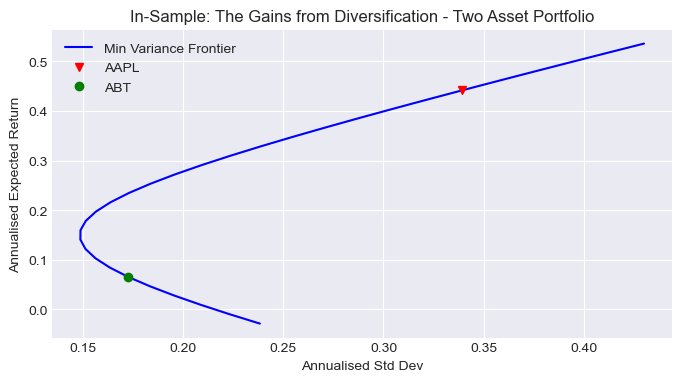

In [71]:
# Two asset example AAPL and ABT

# Monthly means, standard deviations and correlations
mu_appl = np.mean(df_is['AAPL'])
mu_abt = np.mean(df_is['ABT'])
sigma_appl = np.std(df_is['AAPL'])
sigma_abt = np.std(df_is['ABT'])
rho = df_is['AAPL'].corr(df_is['ABT'])

# Annualised means, standard deviations and correlations
mu_appl_annual = mu_appl*12
mu_abt_annual = mu_abt*12
sigma_appl_annual = sigma_appl*np.sqrt(12)
sigma_abt_annual = sigma_abt*np.sqrt(12)

print("AAPL annualised mean is", np.round(mu_appl_annual,3))
print("ABT annualised mean is", np.round(mu_abt_annual,3))
print("AAPL annualised std is", np.round(sigma_appl_annual,3))
print("ABT annualised std is", np.round(sigma_abt_annual,3))
print("AAPL and ABT correlation coffecient is", np.round(rho,3))

# w is a 1d array of weights
w = np.linspace(-0.25, 1.25, 31)

# Portfolio expected return
mu_port = w*mu_appl_annual + (1-w)*mu_abt_annual

# Portfolio variance and standard deviation
var_port = (w**2)*sigma_appl_annual**2 + ((1-w)**2)*sigma_abt_annual**2 + 2*w*(1-w)*rho*sigma_appl_annual*sigma_abt_annual
sigma_port = np.sqrt(var_port)

# Plot
# plt.plot(sigma_port, mu_port,'b-', sigma_appl_annual, mu_appl_annual, 'rv', sigma_abt_annual, mu_abt_annual,'go')
plt.plot(sigma_port, mu_port,'b-', label='Min Variance Frontier')
plt.plot(sigma_appl_annual, mu_appl_annual, 'rv', label='AAPL')
plt.plot(sigma_abt_annual, mu_abt_annual,'go', label='ABT')
plt.xlabel('Annualised Std Dev')
plt.ylabel('Annualised Expected Return')
plt.title('In-Sample: The Gains from Diversification - Two Asset Portfolio')
plt.legend()
plt.show()

_Multi Asset and Index Portfolios_

In [72]:
# In sample Fama French mean market return and std_dev (for plotting)

# Isolate array of FF market returns over in sample period 
ff_mkt_rf = df_sp_100_exrets_new.loc[:is_end_date,'mkt-rf'].values
rf = df_sp_100_exrets_new.loc[:is_end_date,'rf'].values
ff_mkt_ret = ff_mkt_rf + rf

# In-sample expected returns vector and standard deviation vector
ff_mu = ff_mkt_ret.mean() 
ff_sigma = ff_mkt_ret.std() 

In [73]:
# In sample SP100 mean market return and std_dev (for plotting)
 
sp100 = df_sp_100_exrets_new.loc[:is_end_date,'SP100'].values
sp100_mu = sp100.mean() 
sp100_sigma = sp100.std()

In [74]:
# In sample Equally Weighted portfolio return and std_dev (for plotting)

ew_port = df_is.loc[:,'AAPL':'XOM'].mean(axis = 1)
ew_port_mu = ew_port.mean() 
ew_port_sigma = ew_port.std()

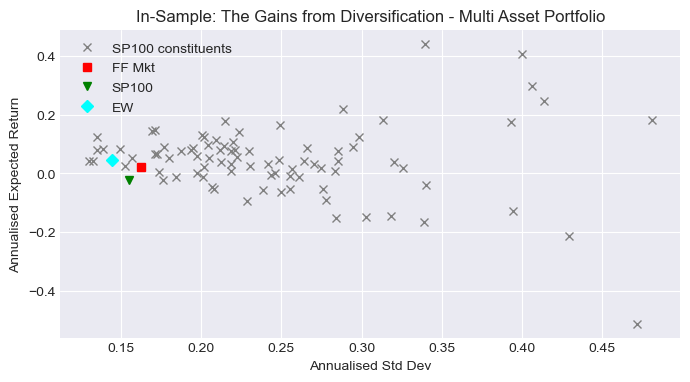

In [75]:
# Recreate graph with SP100 constituents assets, SP100, EW, FF, GMVP, portfolio returns (In sample)
plt.plot(sigma*np.sqrt(12), mu_1d*12, 'x', label='SP100 constituents', color='gray')
# plt.plot(sigma_gmvp_is*np.sqrt(12), mu_gmvp_is*12, 'x', label='GVMP', color='orange')
plt.plot(ff_sigma*np.sqrt(12), ff_mu*12, 's', label='FF Mkt', color='red')
plt.plot(sp100_sigma*np.sqrt(12), sp100_mu*12, 'v', label='SP100', color='green')
plt.plot(ew_port_sigma*np.sqrt(12), ew_port_mu*12, 'D', label='EW', color='cyan')
# plt.plot(sigma_p2_is*np.sqrt(12), mu_p2_is*12, 'x', label='Portfolio 2', color='blue')

plt.xlabel('Annualised Std Dev')
plt.ylabel('Annualised Expected Return')
plt.title('In-Sample: The Gains from Diversification - Multi Asset Portfolio')
plt.legend()
plt.show()

#### Cumulative Returns

In [76]:
# Cumulative returns

cr_mvp = np.cumprod(1+df_os['GMVP'])
cr_ew = np.cumprod(1+df_os['EW'])
# cr_p2 = np.cumprod(1+df_os['P2'])
cr_sp100 = np.cumprod(1+df_sp_100_exrets_new.loc[os_start_date:,'SP100'])

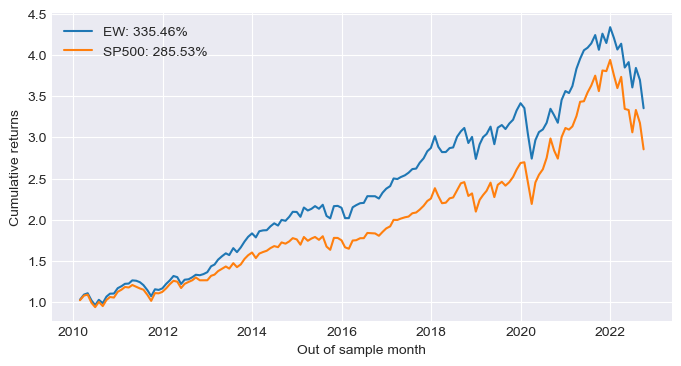

In [77]:
# Plot

# plt.plot(cr_mvp, label = f'GMVP: {cr_mvp[-1]*100:.2f}%')
plt.plot(cr_ew, label = f'EW: {cr_ew[-1]*100:.2f}%')
# plt.plot(cr_p2, label = f'P2: {cr_p2[-1]*100:.2f}%')
plt.plot(cr_sp100, label = f'SP500: {cr_sp100[-1]*100:.2f}%')
plt.xlabel('Out of sample month')
plt.ylabel('Cumulative returns')
plt.legend()
plt.show()

#### Capital Asset Pricing Model
Use the CAPM model to evaluate the out-of-sample performance of the two portfolios. Run an ex-post regression with the excess portfolio returns as the dependent variable and the excess S&P 100 market returns as the independent variable.

In [78]:
# Calculcate excess returns
cols = ['GMVP', 'P2', 'SP100'] 
df_os_exret = df_os.apply(lambda x: x[cols] - x['rf'], axis=1)
df_os_exret.columns = ['exret' + str(col) for col in cols]
display(df_os_exret)

,exretGMVP,exretP2,exretSP100
Date,,,
2010-02-26,0.009169,-2.020022e-01,0.021916
2010-03-31,-0.090703,5.748412e+11,0.055343
2010-04-30,-0.061664,-9.860676e+11,0.009889
2010-05-31,0.038425,2.719412e+11,-0.091557
2010-06-30,0.464730,1.916813e+13,-0.053011
...,...,...,...
2022-05-31,-0.524322,2.081132e+13,-0.004544
2022-06-30,0.289030,-1.884116e+13,-0.081818
2022-07-29,-0.198004,-2.529075e+13,0.087860


In [79]:
portfolios = ['GMVP', 'P2'] # Define list of portfolios 

In [80]:
# Regression
capm_model_result = {} #Setting up empty dictionary

for p in portfolios:
    Y = df_os_exret['exret' + p] #dependent variables
    X = df_os_exret['exretSP100'] #independent variable
    capm_model = smf.ols(formula='Y ~ X',data=df_os_exret) #estimate each OLS regression
    capm_name = 'SP100 CAPM Ex-Post Regression: ' + p #name each regression
    capm_regress_result = capm_model.fit() #fit each model
    print(capm_name, '\n', capm_regress_result.summary(), '\n') #print each regression

    capm_model_result[p] = capm_regress_result  #Filling dictionary with each model

SP100 CAPM Ex-Post Regression: GMVP 
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.04471
Date:                Mon, 05 Dec 2022   Prob (F-statistic):              0.833
Time:                        21:45:30   Log-Likelihood:                -236.76
No. Observations:                 152   AIC:                             477.5
Df Residuals:                     150   BIC:                             483.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

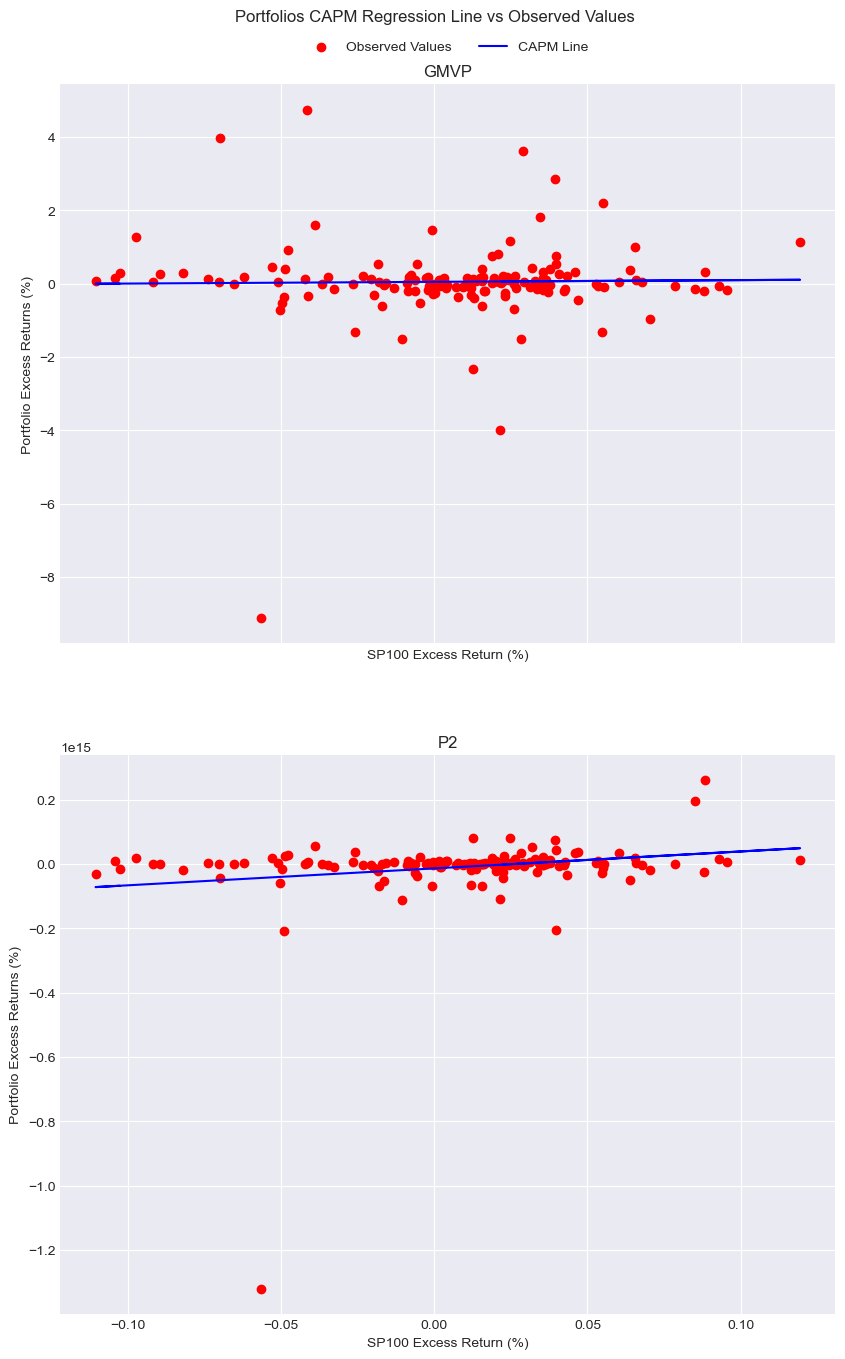

In [81]:
# Plot CAPM
fig, axs = plt.subplots(nrows=len(portfolios), ncols=1, figsize=(10,15), sharex=True)

for k, p in enumerate(portfolios):
    ax = axs[k]
    predict = capm_model_result[p].predict()
    ax.scatter(df_os_exret['exretSP100'], df_os_exret['exret' + p], 
               label='Observed Values', color = 'red') # plot observed values
    ax.plot(df_os_exret['exretSP100'], predict, label = 'CAPM Line', color = 'blue') # draw regression line
    ax.set_title(p)
    ax.set_xlabel("SP100 Excess Return (%)")
    ax.set_ylabel("Portfolio Excess Returns (%)")
plt.suptitle("Portfolios CAPM Regression Line vs Observed Values")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=2, fancybox=True, shadow=True) #Adjusting legend position
plt.subplots_adjust(top=0.93) #Adjusting title position
plt.show()

#### Porfolio Returns Distribution

In [82]:
# plot_series_v_normal(df_os['GMVP'], 'GMVP Returns', 
#                      'Global Minimum Variance Portfolio Returns Distribution v Normal Distribution')
# plot_series_v_normal(df_os['P2'], 'Portfolio 2 Returns', 
#                      'Portfolio 2 Returns Distribution v Normal Distribution')

### Question 3 Commentary

#### SP100 and ETF data differences



## Project Allocation

__Odhran Murphy__

Downloading SP100 and SP500 constituent data and management of GitHub repository. 
Question 3. 

<br>

__Hugo Brady__

Question 1

<br>

__Mark Mullins__

Question 2
Formatting of code and report

## References

### Question 1
seekingalpha.com. (n.d.). Average Return of the Stock Market: S&P 500, Dow Jones | Seeking Alpha. [online] Available at: https://seekingalpha.com/article/4502739-average-stock-market-return.

am.jpmorgan.com. (n.d.). Value vs growth investing: A historical overview | J.P. Morgan Asset Management. [online] Available at: https://am.jpmorgan.com/gb/en/asset-management/adv/insights/value-vs-growth-investing/.

Fama, E.F. and French, K.R. (2015). A five-factor asset pricing model. Journal of Financial Economics, 116(1), pp.1–22. doi:10.1016/j.jfineco.2014.10.010.

Womack, K.L. and Zhang, Y. (2003). Understanding Risk and Return, the CAPM, and the Fama-French Three-Factor Model. [online] papers.ssrn.com. Available at: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=481881.

Musawa, N., Kapena, P.S. and Shikaputo, D.C. (2018). A COMPARATIVE ANALYSIS OF FAMA-FRENCH FIVE AND THREE-FACTOR MODEL IN EXPLAINING STOCK RETURNS VARIATION. International Journal of Economics, [online] 3(1), pp.30–48. Available at: https://iprjb.org/journals/index.php/IJECON/article/view/690 [Accessed 5 Dec. 2022].
 
Pure play asset management | Robeco.com. (2022). Fama-French 5-factor model: why more is not always better. [online] Available at: https://www.robeco.com/en/insights/2022/03/fama-french-5-factor-model-why-more-is-not-always-better.html.
 Akbar, U. S., Bhutto, N. A. and Rajput, S. K. O. (2021) “Does Five-Factor Model Perform Better Than Three Factor Model? Evidence from Developed Countries of The Asia Pacific Region”, iRASD Journal of Economics, 3(2), pp. 119–132. doi: 10.52131/joe.2021.0302.0030.


### Question 2

### Question 3

## Appendix
